# Plot results of BP mitigation methods (IRIS)

Before you run this notebook, check the Save folder.

If the save folder is empty, you need to run the notebooks `TrainEpoch.ipynb`, then `capacity-ed.ipynb`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os.path import exists

from qiskit import Aer, IBMQ
from qiskit.utils import QuantumInstance
from qiskit.utils import algorithm_globals
from qiskit.algorithms.optimizers import COBYLA, NELDER_MEAD, SLSQP, SPSA
from qiskit.opflow import Z, X, I, StateFn, PauliExpectation, Gradient
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN, OpflowQNN
from qiskit_machine_learning.neural_networks import EffectiveDimension
from qiskit_machine_learning.algorithms.classifiers import VQC, NeuralNetworkClassifier
from qiskit.quantum_info import SparsePauliOp

from Components.circuits import preTrainedBlockGenerator, layerwise_training, featureMapGenerator, AnsatzGenerator
from Components.data import iris
from Components.utils import plot_loss, score, parity, classification_callback, plot_objfn_range, result_to_objfun_dataframes, save_results, smooth, plot_score_range
from Components.train import create_qnn, sampling_experiment

from qiskit.providers.fake_provider import FakeVigo, FakePerth

import pandas as pd

import time

from IPython.display import clear_output

%matplotlib inline
import matplotlib as mpl

In [2]:
from Components.log_ops import plot_method_data, logs_to_data

In [3]:
ITER_STEP_SIZE = 25
MAX_INST = 10
LOGS_PATH = './Logs-IRIS-v4'
DATA_SET = 'IRIS'
n = [75, 90, 105, 120, 135, 150, 200, 300, 400, 1000, 5000, 8000, 10000, 40000, 60000, 100000, 150000, 200000, 500000, 1000000]
DPI_RES = 200

## Utilities

In [4]:
def plot_results(data, title='Instance Losses', dlabel='inst#', xlabel='Loss', ylabel='Iteration'):
    # create figure and axis
    fig, ax = plt.subplots()
    fig.set_figheight(4)
    fig.set_figwidth(8)
    
    # transposing (switchung rows and columns) of DataFrame df and
    # plot a line for each column on the axis ax, which was created previously
    for i in range(len(data)):
        data[i].T.plot(ax=ax, label=f'inst# {i}', figsize=(5, 3))
    ax.legend([f'{dlabel} {i}' for i in range(len(data))],
             loc='lower center', bbox_to_anchor=(0.5, -0.4),
             ncol=5, fancybox=True, fontsize='x-small') #, shadow=True)
    ax.set_xlabel(xlabel, fontsize=10)
    ax.set_ylabel(ylabel, fontsize=10)
    ax.set_title(title)

    plt.show()

## Retrieve data

In [5]:
# Get data from logs
losses, weights, train_acc, test_acc, local_ed, global_ed, dims = \
    logs_to_data(LOGS_PATH, methods=['m0', 'm1', 'm2', 'm3'])

Existing archive: ./Logs-IRIS-v4
   Found method: m0
      Method m0 had 10 valid, 0 missing, and 0 in error instances
   Found method: m1
      Method m1 had 10 valid, 0 missing, and 0 in error instances
   Found method: m2
      Method m2 had 10 valid, 0 missing, and 0 in error instances
   Found method: m3
      Method m3 had 10 valid, 0 missing, and 0 in error instances


In [6]:
# Convert all data to legacy format

LossFunctions = [pd.concat(losses[k]) for k in losses.keys()]

Weights_0 = weights['m0']
Weights_1 = weights['m1']
Weights_2 = weights['m2']
Weights_3 = weights['m3']

d = [dims[k] for k in dims.keys()]

Local_eff_0 = local_ed['m0']
Local_eff_1 = local_ed['m1']
Local_eff_2 = local_ed['m2']
Local_eff_3 = local_ed['m3']

Global_eff_0 = global_ed['m0']
Global_eff_1 = global_ed['m1']
Global_eff_2 = global_ed['m2']
Global_eff_3 = global_ed['m3']

test_scores = [pd.concat(test_acc[k]) for k in test_acc.keys()]
train_scores = [pd.concat(train_acc[k]) for k in train_acc.keys()]

In [7]:
# Retrieve the number of iterations conducted

MAX_ITER = LossFunctions[0].iloc[0].shape[0]
MAX_ITER

150

# Traditional way of presenting local effective dimension (linear scale)
*Note that local effective dimension is non-monotonic, but it aligns with best test scores.*

In [8]:
m = 0
inst = 7

method = [Local_eff_0, Local_eff_1, Local_eff_2, Local_eff_3]
weight = [Weights_0, Weights_1, Weights_2, Weights_3]
leff = method[m]
weff = weight[m]

[]

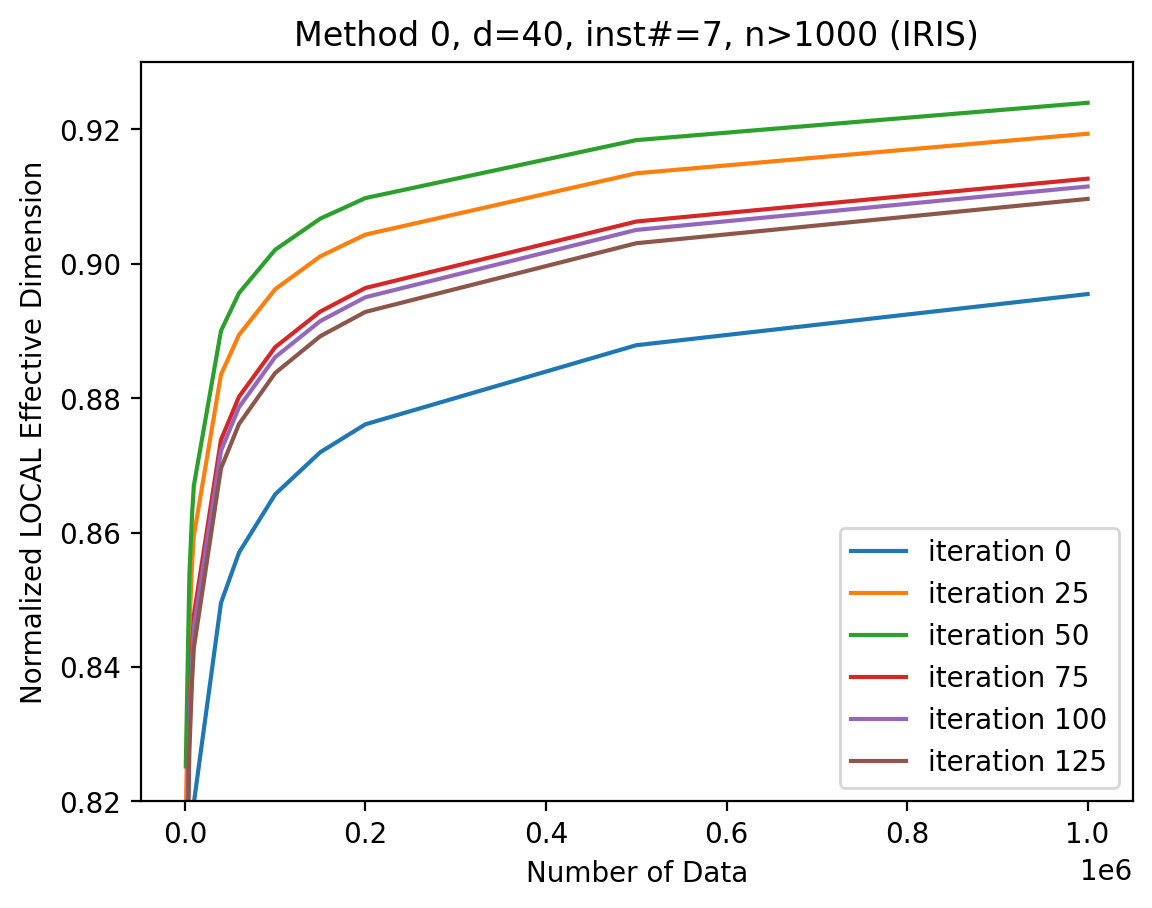

In [9]:
start_n = 9
plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(leff[inst])):
    nx = n[start_n:]
    ny = (np.array(leff[inst].iloc[i]) / len(weight[m][i].columns))[start_n:]
    plt.plot(nx, ny, label=f"iteration {i*ITER_STEP_SIZE}")

plt.xlabel("Number of Data")
plt.ylabel("Normalized LOCAL Effective Dimension")
plt.title(f'Method 0, d={d[2]}, inst#={inst}, n>{n[start_n]} ({DATA_SET})')
plt.legend(loc='best')
plt.ylim(0.82, 0.93)

plt.plot()
# plt.semilogx()

(0.65, 1.0)

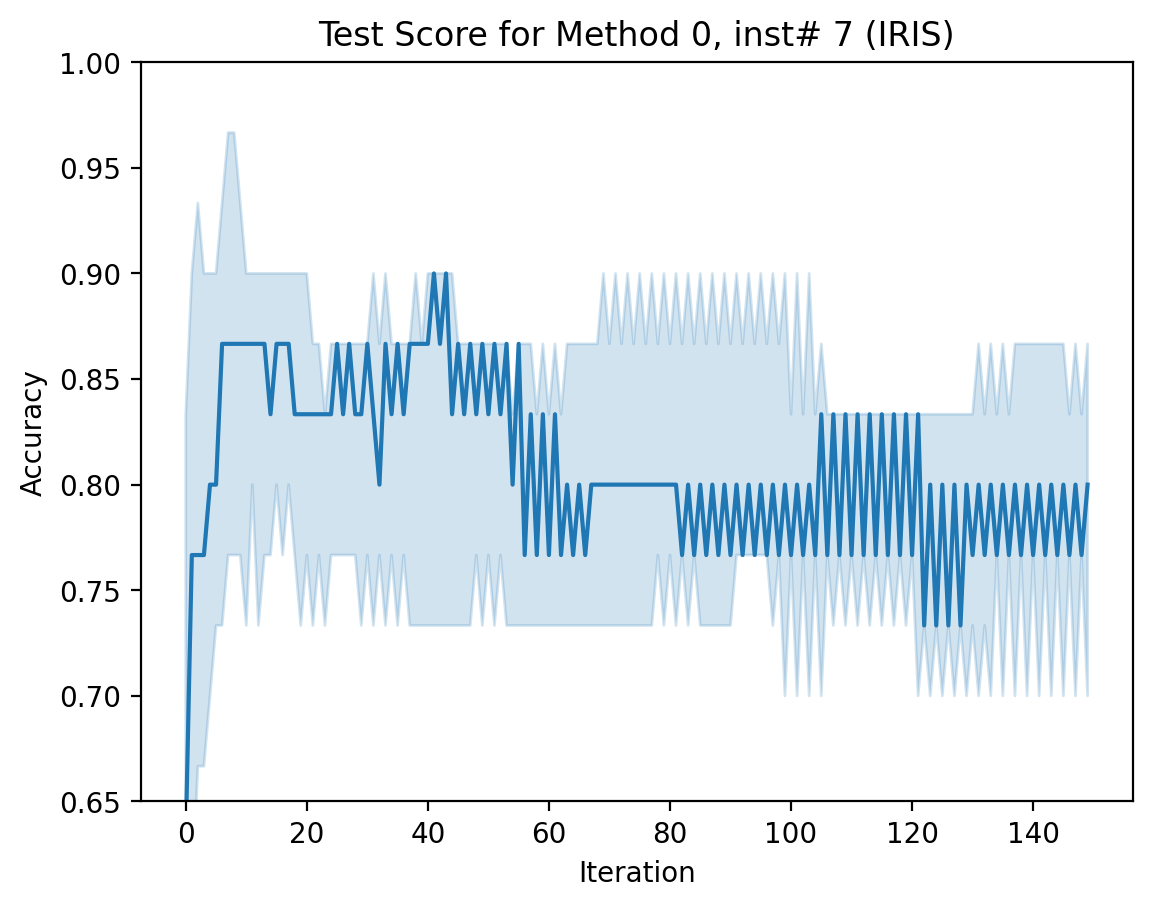

In [10]:
smooth_weight=0
color = ['tab:blue', 'tab:orange' ,'tab:green', 'tab:red']

select = test_scores[m]
max = smooth(select.max(), smooth_weight)
min = smooth(select.min(), smooth_weight)
select_curve = smooth(select.iloc[inst], smooth_weight)


plt.rcParams['figure.dpi'] = DPI_RES
plt.plot(range(0, test_scores[m].shape[1]), select_curve, color = color[m])
plt.fill_between(range(0, test_scores[m].shape[1]), max, min, color = color[m], alpha = 0.2)

plt.ylim(0.2, 1.1)
plt.title(f'Test Score for Method {m}, inst# {inst} ({DATA_SET})')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.ylim(0.65, 1)

# Local effective dimension for the selected instance of each method (log scale)

[]

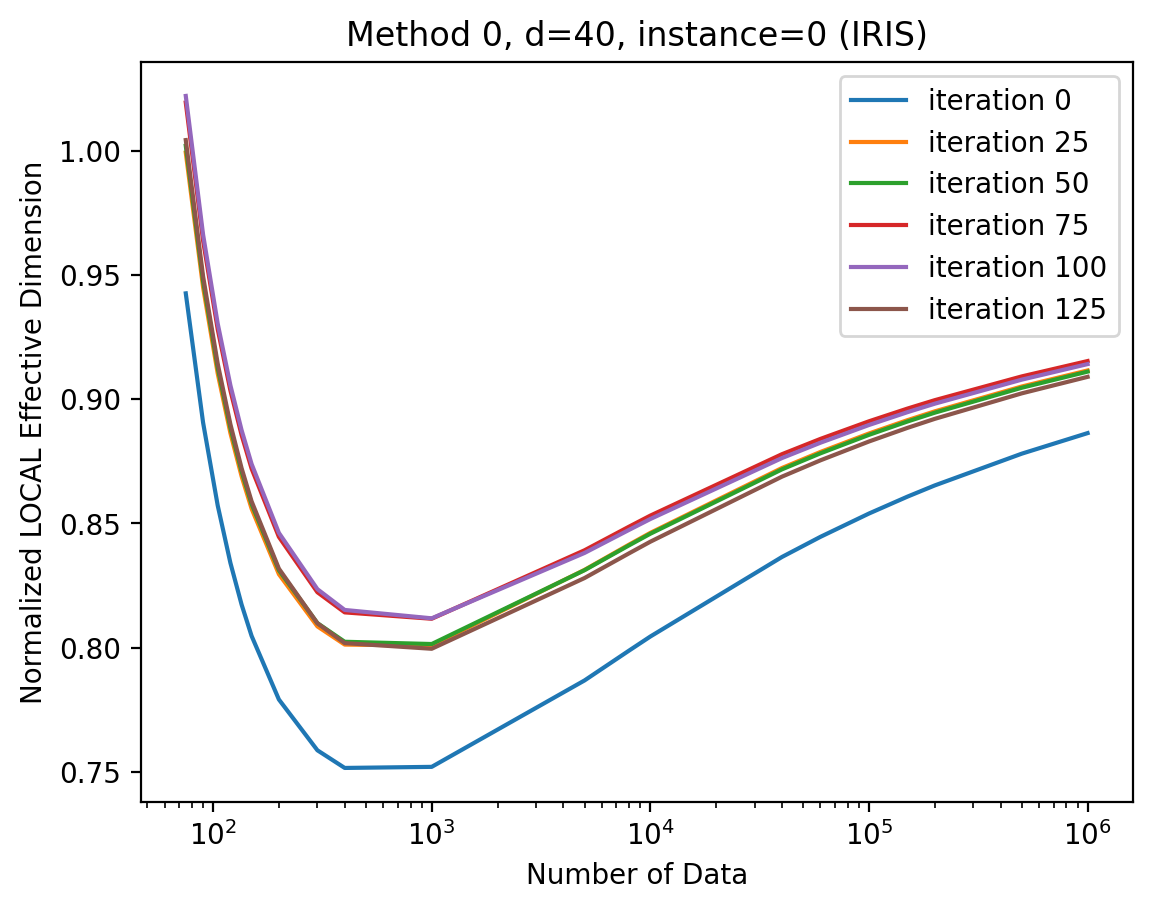

In [11]:
m = 0
sel_instance = 0

plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(Local_eff_0[0])):
    plt.plot(n, np.array(Local_eff_0[sel_instance].iloc[i]) / len(Weights_0[i].columns), label=f"iteration {i*ITER_STEP_SIZE}")

plt.xlabel("Number of Data")
plt.ylabel(f"Normalized LOCAL Effective Dimension")
plt.title(f'Method 0, d={d[0]}, instance={sel_instance} ({DATA_SET})')
plt.legend()
plt.plot()
plt.semilogx()

[]

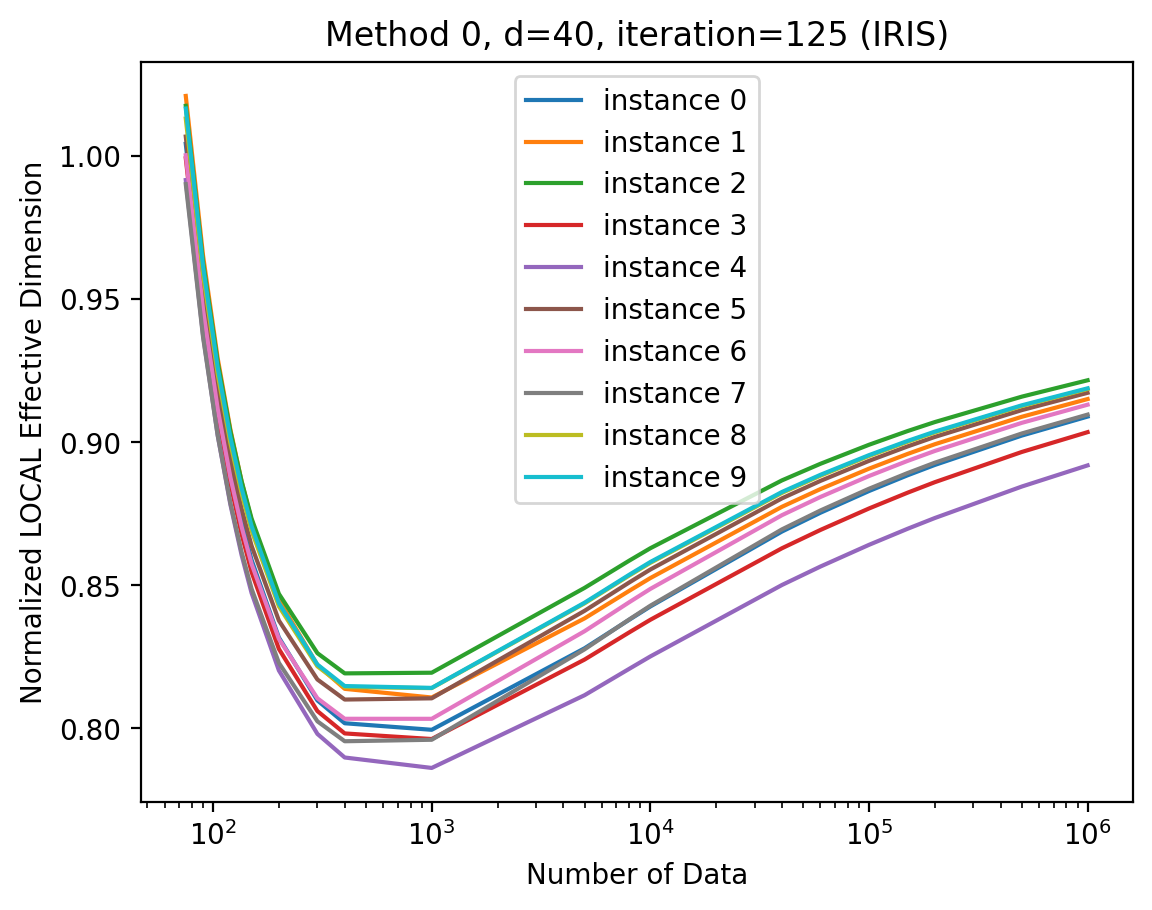

In [12]:
### Plot all method 0 instances at the selected iteration
sel_iter = len(Local_eff_0[0])-1
plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(Local_eff_0)):
    plt.plot(n, np.array(Local_eff_0[i].iloc[sel_iter]) / len(Weights_0[i].columns), label=f"instance {i}")

plt.xlabel("Number of Data")
plt.ylabel("Normalized LOCAL Effective Dimension")
plt.title(f'Method 0, d={d[0]}, iteration={sel_iter*ITER_STEP_SIZE} ({DATA_SET})')
plt.legend()
plt.plot()
plt.semilogx()

[]

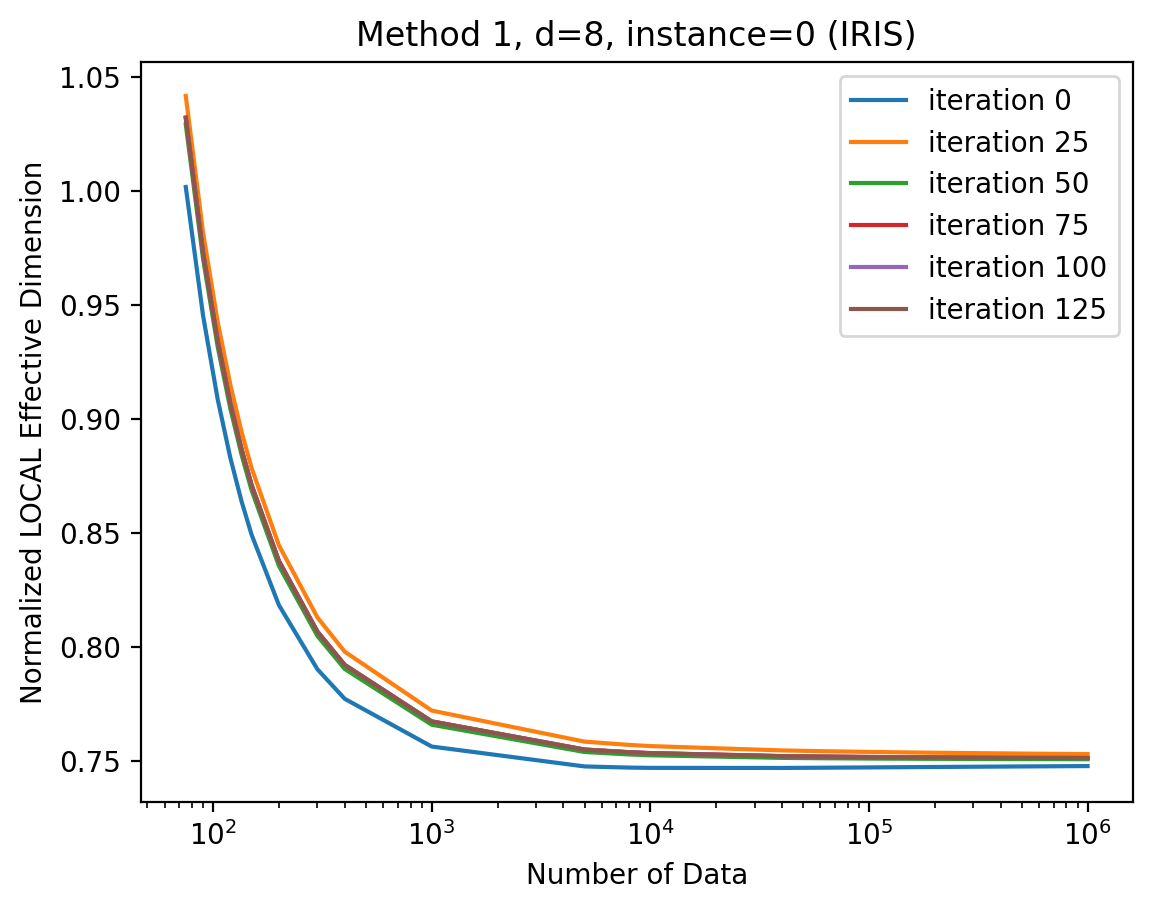

In [13]:
sel_instance = 0
plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(Local_eff_1[0])):
    plt.plot(n, np.array(Local_eff_1[sel_instance].iloc[i]) / len(Weights_1[i].columns), label=f"iteration {i*ITER_STEP_SIZE}")

plt.xlabel("Number of Data")
plt.ylabel("Normalized LOCAL Effective Dimension")
plt.title(f'Method 1, d={d[1]}, instance={sel_instance} ({DATA_SET})')
plt.legend()
plt.plot()
plt.semilogx()

[]

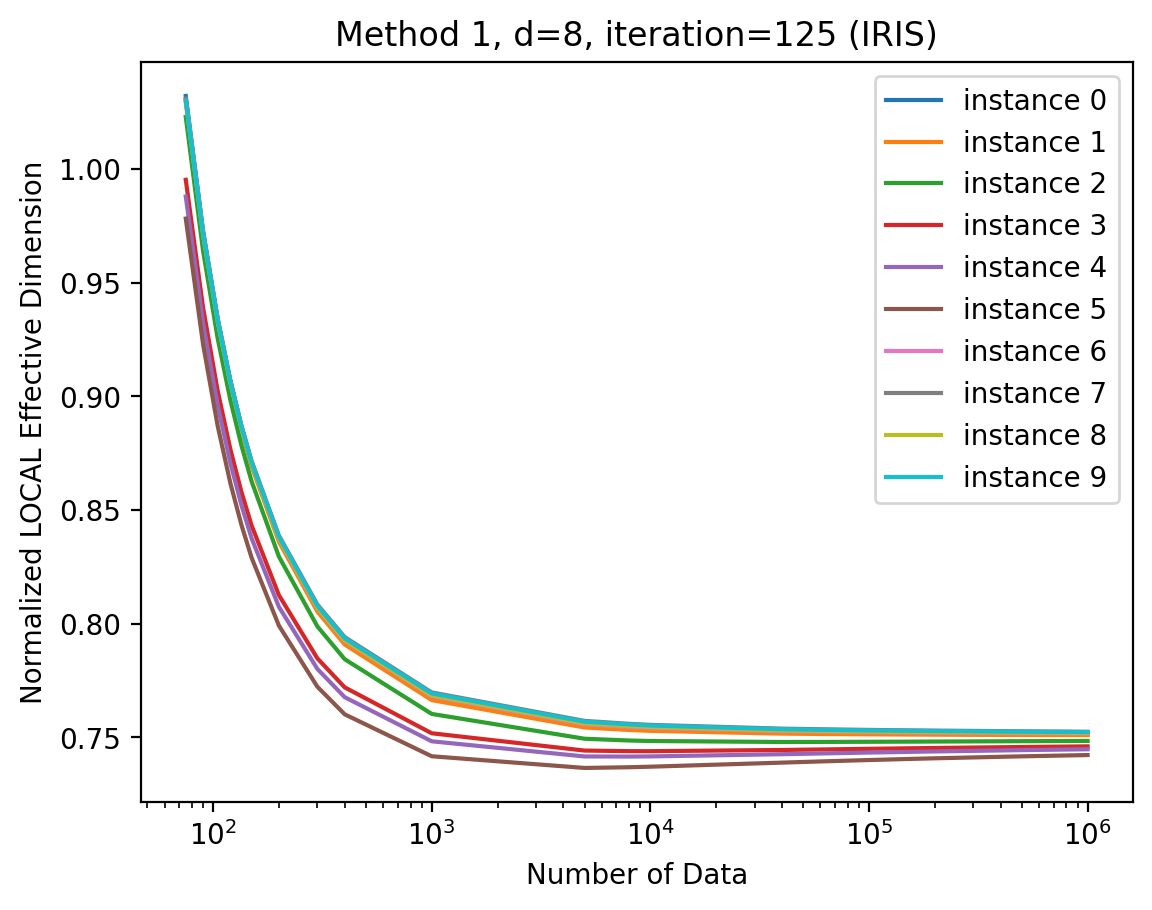

In [14]:
### Plot all method 1 instances at the selected iteration
sel_iter = len(Local_eff_1[0])-1
plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(Local_eff_1)):
    plt.plot(n, np.array(Local_eff_1[i].iloc[sel_iter]) / len(Weights_1[i].columns), label=f"instance {i}")

plt.xlabel("Number of Data")
plt.ylabel("Normalized LOCAL Effective Dimension")
plt.title(f'Method 1, d={d[1]}, iteration={sel_iter*ITER_STEP_SIZE} ({DATA_SET})')
plt.legend()
plt.plot()
plt.semilogx()

[]

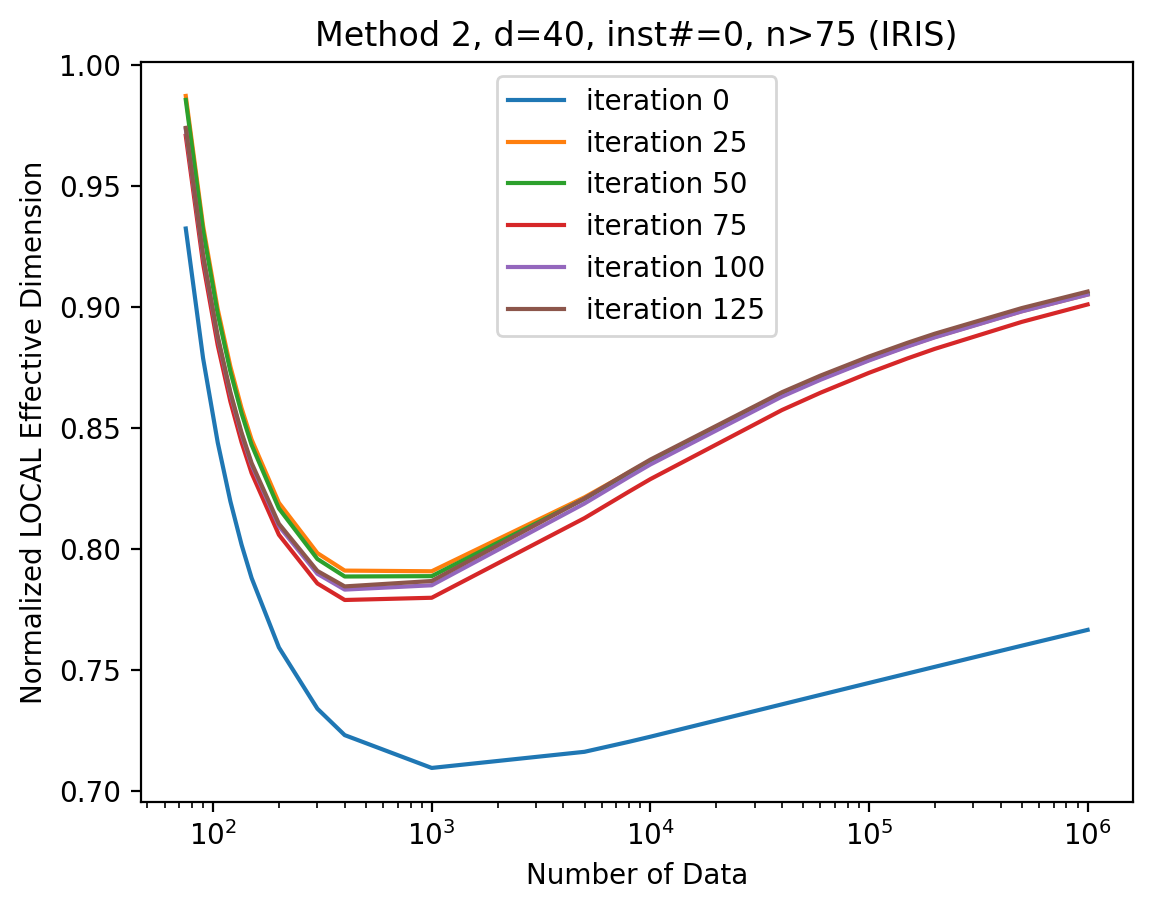

In [15]:
sel_instance = 0
start_n = 0
plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(Local_eff_2[sel_instance])):
    nx = n[start_n:]
    ny = (np.array(Local_eff_2[sel_instance].iloc[i]) / len(Weights_2[i].columns))[start_n:]
    plt.plot(nx, ny, label=f"iteration {i*ITER_STEP_SIZE}")

plt.xlabel("Number of Data")
plt.ylabel("Normalized LOCAL Effective Dimension")
plt.title(f'Method 2, d={d[2]}, inst#={sel_instance}, n>{n[start_n]} ({DATA_SET})')
plt.legend()
plt.plot()
plt.semilogx()

[]

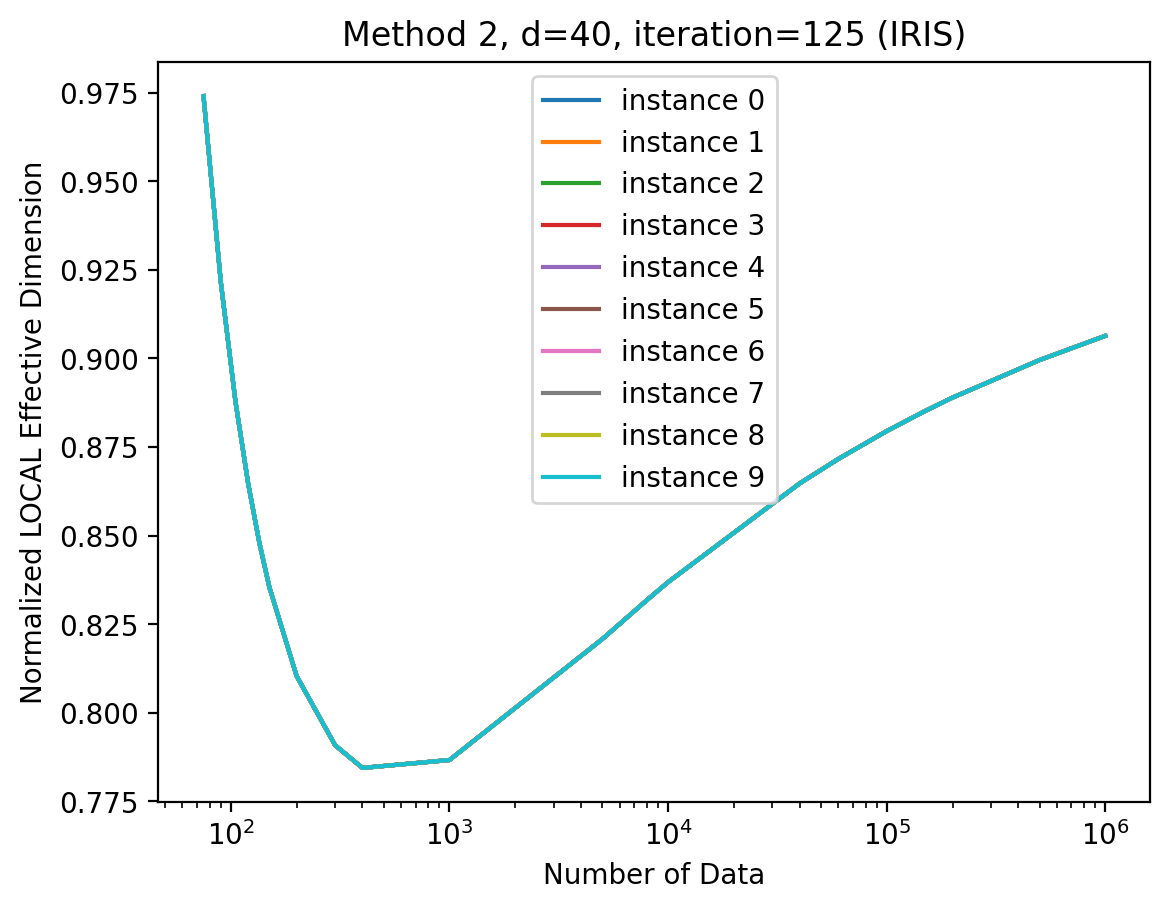

In [16]:
### Plot all method 2 instances at the selected iteration
sel_iter = len(Local_eff_2[0])-1
plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(Local_eff_2)):
    plt.plot(n, np.array(Local_eff_2[i].iloc[sel_iter]) / len(Weights_2[i].columns), label=f"instance {i}")

plt.xlabel("Number of Data")
plt.ylabel("Normalized LOCAL Effective Dimension")
plt.title(f'Method 2, d={d[2]}, iteration={sel_iter*ITER_STEP_SIZE} ({DATA_SET})')
plt.legend()
plt.plot()
plt.semilogx()

[]

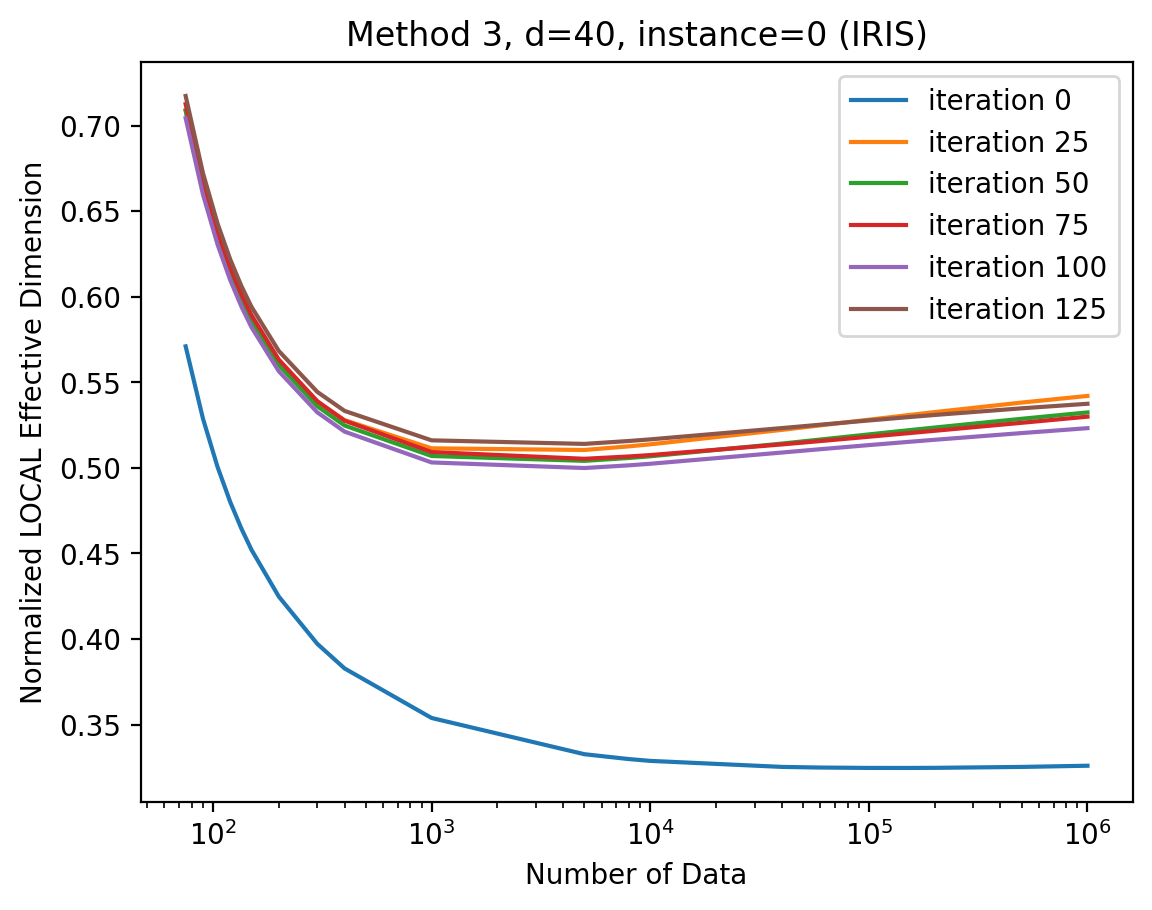

In [17]:
sel_instance = 0
plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(Local_eff_3[0])):
    plt.plot(n, np.array(Local_eff_3[sel_instance].iloc[i]) / len(Weights_3[i].columns), label=f"iteration {i*ITER_STEP_SIZE}")

plt.xlabel("Number of Data")
plt.ylabel("Normalized LOCAL Effective Dimension")
plt.title(f'Method 3, d={d[3]}, instance={sel_instance} ({DATA_SET})')
plt.legend()
plt.plot()
plt.semilogx()

[]

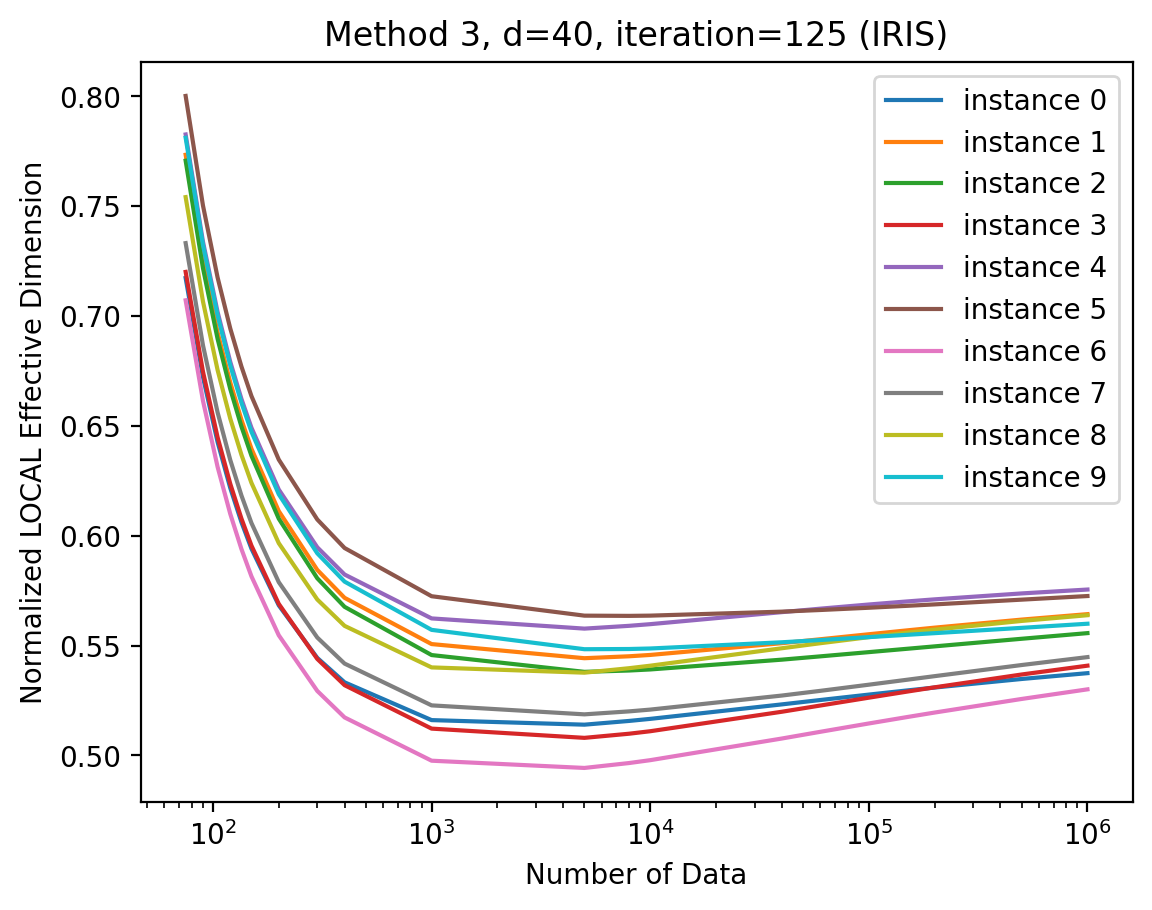

In [18]:
### Plot all method 3 instances at the selected iteration
sel_iter = len(Local_eff_3[0])-1
plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(Local_eff_3)):
    plt.plot(n, np.array(Local_eff_3[i].iloc[sel_iter]) / len(Weights_3[i].columns), label=f"instance {i}")

plt.xlabel("Number of Data")
plt.ylabel("Normalized LOCAL Effective Dimension")
plt.title(f'Method 3, d={d[3]}, iteration={sel_iter*ITER_STEP_SIZE} ({DATA_SET})')
plt.legend()
plt.plot()
plt.semilogx()

# Plot Local Effective Dimension and training results showing variance across instance results

[]

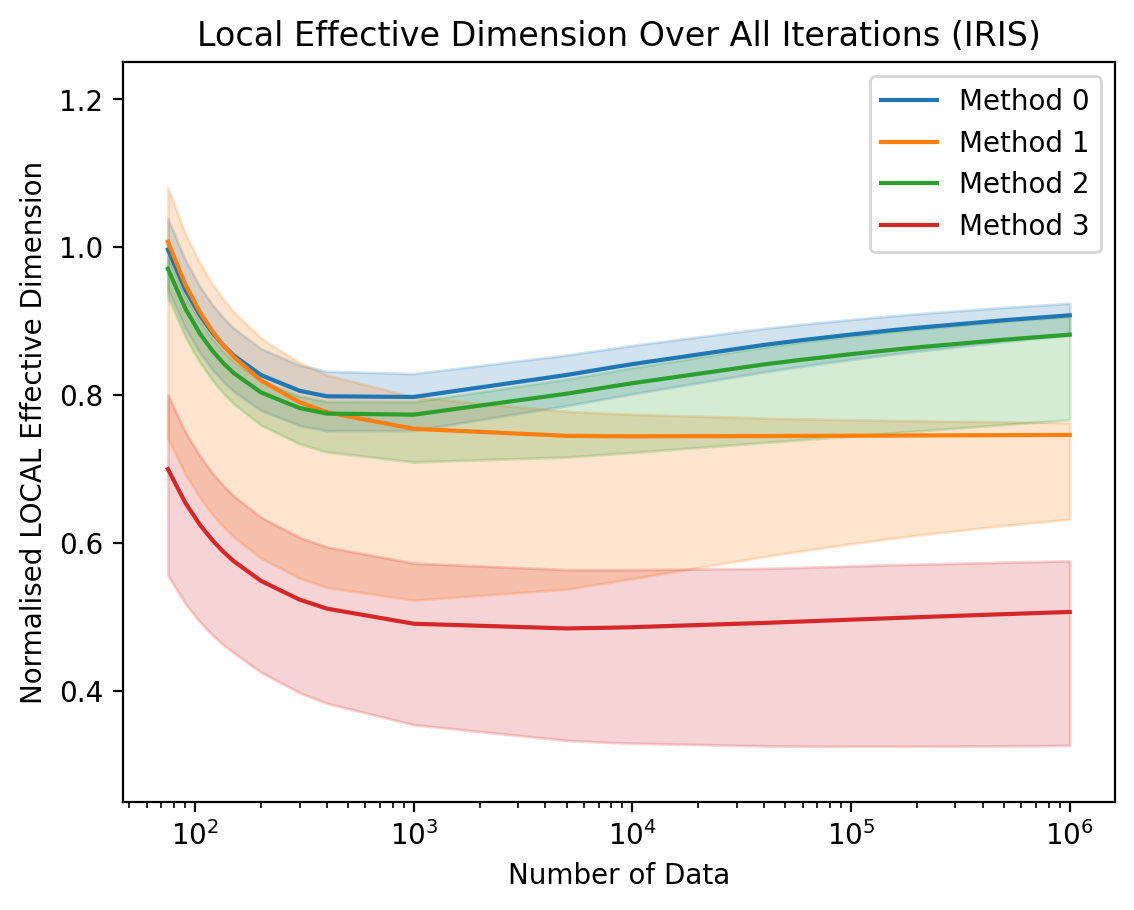

In [19]:
color = ['tab:blue', 'tab:orange' ,'tab:green', 'tab:red']
local_eff_pd = [
    pd.concat(Local_eff_0), 
    pd.concat(Local_eff_1), 
    pd.concat(Local_eff_2),
    pd.concat(Local_eff_3)
]

plt.rcParams['figure.dpi'] = DPI_RES
for c in range(len(local_eff_pd)):
    normal_le = local_eff_pd[c] / d[c]
    max = normal_le.max()
    min = normal_le.min()
    mean = normal_le.mean()

    plt.plot(n, mean, color = color[c], label = f'Method {c}')
    plt.fill_between(n, max, min, color = color[c], alpha = 0.2)

plt.title(f'Local Effective Dimension Over All Iterations ({DATA_SET})')
plt.ylim(0.25, 1.25)
plt.xlabel("Number of Data")
plt.ylabel("Normalised LOCAL Effective Dimension")
plt.legend(loc = 'best')
plt.plot()
plt.semilogx()

In [20]:
L_before = [
    pd.DataFrame([Local_eff_0[i].iloc[0] for i in range(len(Local_eff_0))]),
    pd.DataFrame([Local_eff_1[i].iloc[0] for i in range(len(Local_eff_1))]),
    pd.DataFrame([Local_eff_2[i].iloc[0] for i in range(len(Local_eff_2))]),
    pd.DataFrame([Local_eff_3[i].iloc[0] for i in range(len(Local_eff_3))])
]

L_after = [
    pd.DataFrame([Local_eff_0[i].iloc[-1] for i in range(len(Local_eff_0))]),
    pd.DataFrame([Local_eff_1[i].iloc[-1] for i in range(len(Local_eff_1))]),
    pd.DataFrame([Local_eff_2[i].iloc[-1] for i in range(len(Local_eff_2))]),
    pd.DataFrame([Local_eff_3[i].iloc[-1] for i in range(len(Local_eff_3))])
]

[]

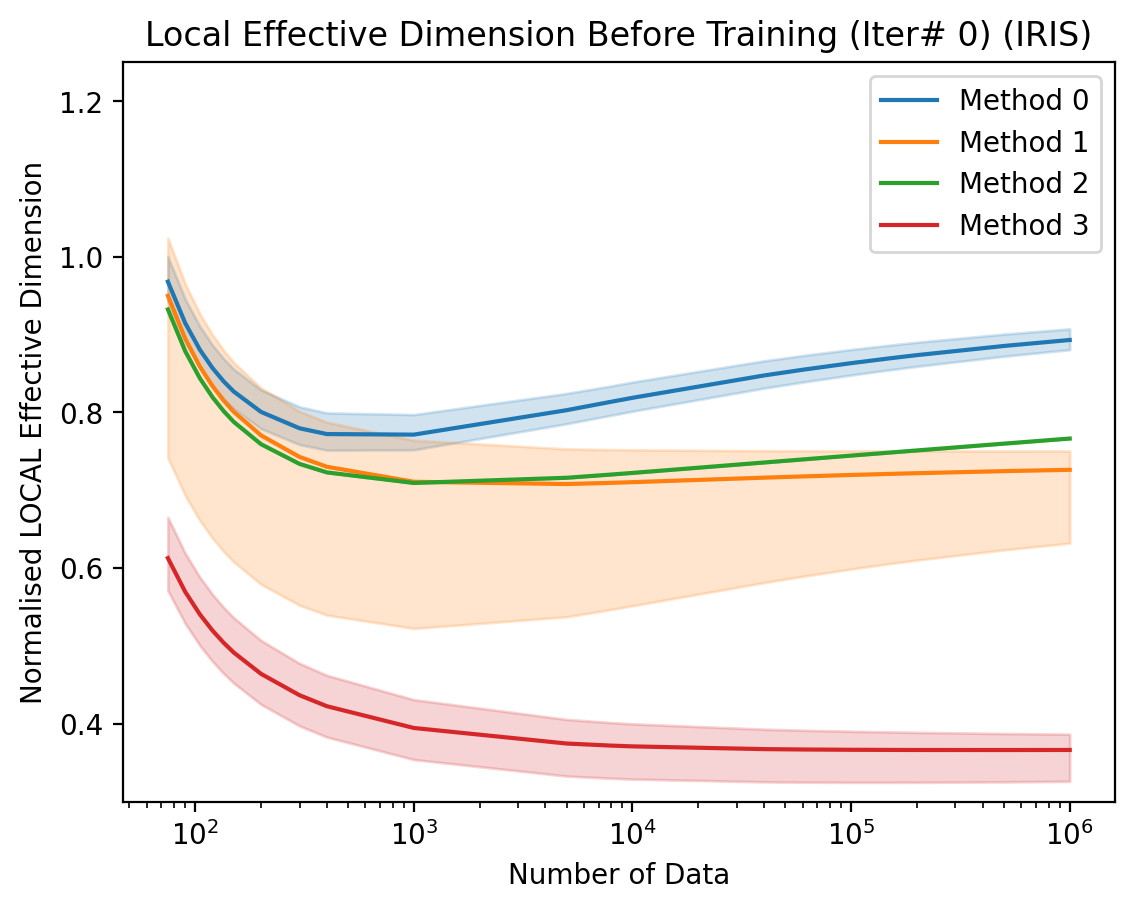

In [21]:
color = ['tab:blue', 'tab:orange' ,'tab:green', 'tab:red']

plt.rcParams['figure.dpi'] = DPI_RES
for c in range(len(L_before)):
    normal_le = L_before[c] / d[c]
    max = normal_le.max()
    min = normal_le.min()
    mean = normal_le.mean()

    plt.plot(n, mean, color = color[c], label = f'Method {c}')
    plt.fill_between(n, max, min, color = color[c], alpha = 0.2)
plt.ylim(0.3, 1.25)
plt.xlabel("Number of Data")
plt.ylabel("Normalised LOCAL Effective Dimension")
plt.legend(loc = 'best')
plt.title(f'Local Effective Dimension Before Training (Iter# 0) ({DATA_SET})')
plt.plot()
plt.semilogx()

[]

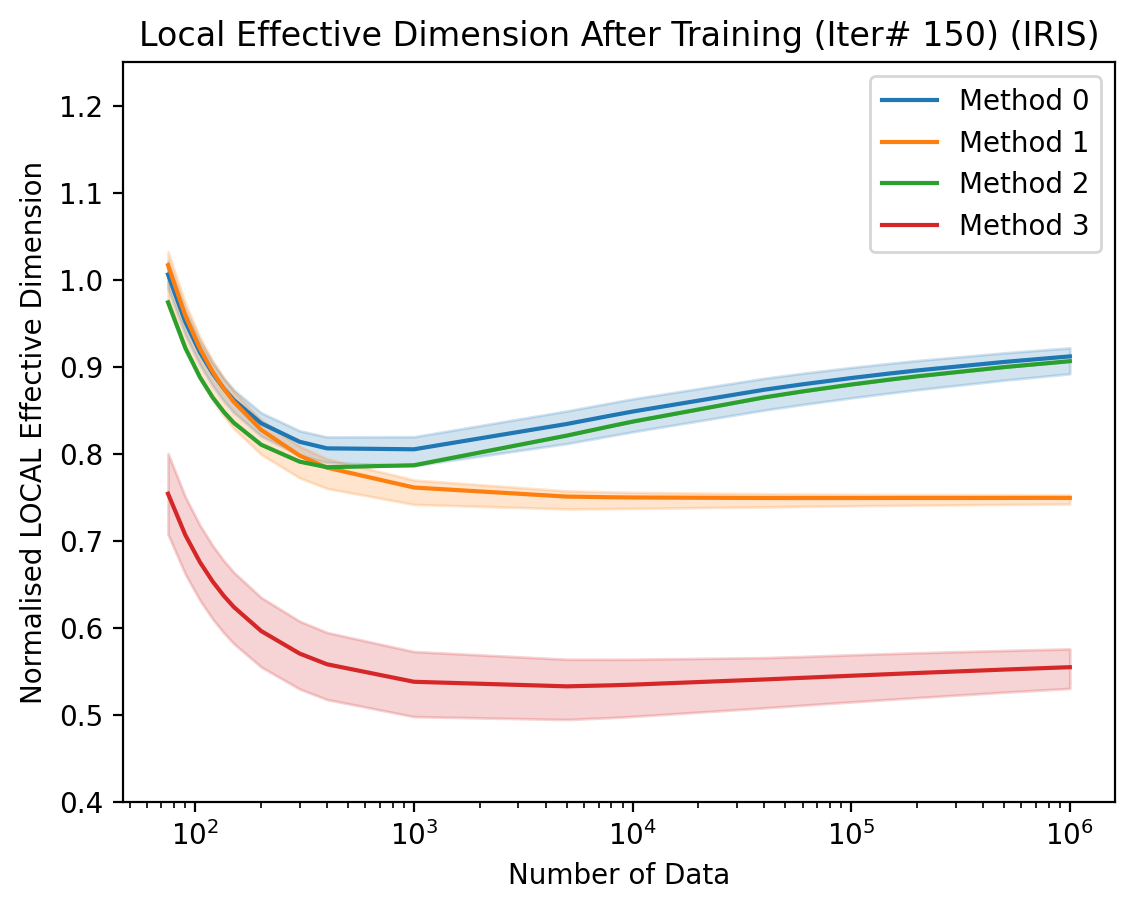

In [22]:
color = ['tab:blue', 'tab:orange' ,'tab:green', 'tab:red']

plt.rcParams['figure.dpi'] = DPI_RES
for c in range(len(L_after)):
    normal_le = L_after[c] / d[c]
    max = normal_le.max()
    min = normal_le.min()
    mean = normal_le.mean()

    plt.plot(n, mean, color = color[c], label = f'Method {c}')
    plt.fill_between(n, max, min, color = color[c], alpha = 0.2)
plt.ylim(0.4, 1.25)
plt.xlabel("Number of Data")
plt.ylabel("Normalised LOCAL Effective Dimension")
plt.legend(loc = 'best')
plt.title(f'Local Effective Dimension After Training (Iter# {MAX_ITER}) ({DATA_SET})')
plt.plot()
plt.semilogx()

### Sweet spot index
The sweet spot for measuring local affective dimension is calculated for each method as follows:
- First, for each method we calculate the mean of test accuracies at each iteration
- Then, we return an index of the first found highest value
- Finally, the index is normalised to consider the step at each measurements were saved

[]

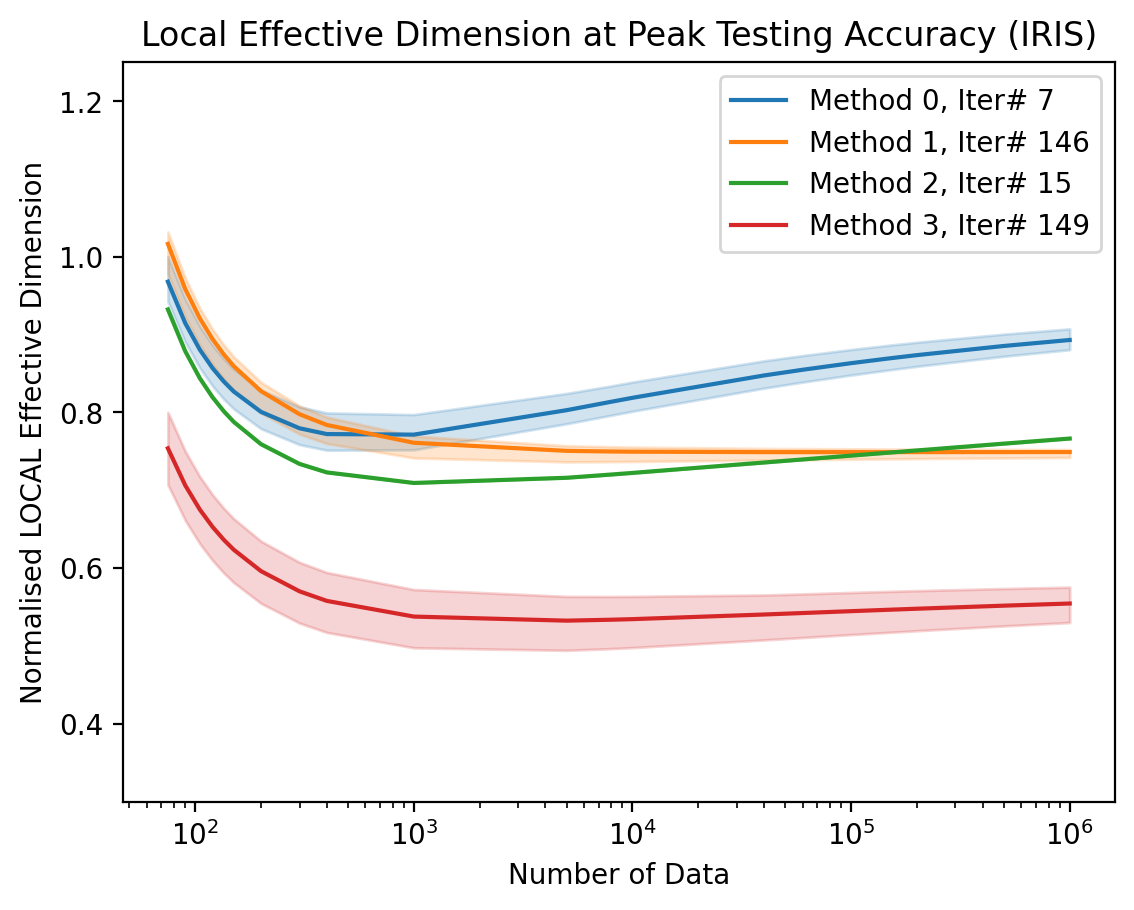

In [23]:
import math

color = ['tab:blue', 'tab:orange' ,'tab:green', 'tab:red']
sweet_spot_index = [(np.argmax(m)/ITER_STEP_SIZE) for m in [np.mean(l, axis=0) for l in test_scores]]
sweet_spot_index_floor = [math.floor(np.argmax(m)/ITER_STEP_SIZE) for m in [np.mean(l, axis=0) for l in test_scores]]

# <- I got the sweet spot based on the Train score vs. iteration graph
L_sweet_spot = [
    pd.DataFrame([Local_eff_0[i].iloc[sweet_spot_index_floor[0]] for i in range(len(Local_eff_0))]),
    pd.DataFrame([Local_eff_1[i].iloc[sweet_spot_index_floor[1]] for i in range(len(Local_eff_1))]),
    pd.DataFrame([Local_eff_2[i].iloc[sweet_spot_index_floor[2]] for i in range(len(Local_eff_2))]),
    pd.DataFrame([Local_eff_3[i].iloc[sweet_spot_index_floor[3]] for i in range(len(Local_eff_3))])
]

plt.rcParams['figure.dpi'] = DPI_RES
for c in range(len(L_sweet_spot)):
    normal_le = L_sweet_spot[c] / d[c]
    max = normal_le.max()
    min = normal_le.min()
    mean = normal_le.mean()

    plt.plot(n, mean, color = color[c], label = f'Method {c}, Iter# {round(sweet_spot_index[c]*ITER_STEP_SIZE)}')
    plt.fill_between(n, max, min, color = color[c], alpha = 0.2)

plt.ylim(0.3, 1.25)
plt.xlabel("Number of Data")
plt.ylabel("Normalised LOCAL Effective Dimension")
plt.legend(loc = 'best')
plt.title(f'Local Effective Dimension at Peak Testing Accuracy ({DATA_SET})')
plt.plot()
plt.semilogx()

# Training performance

[]

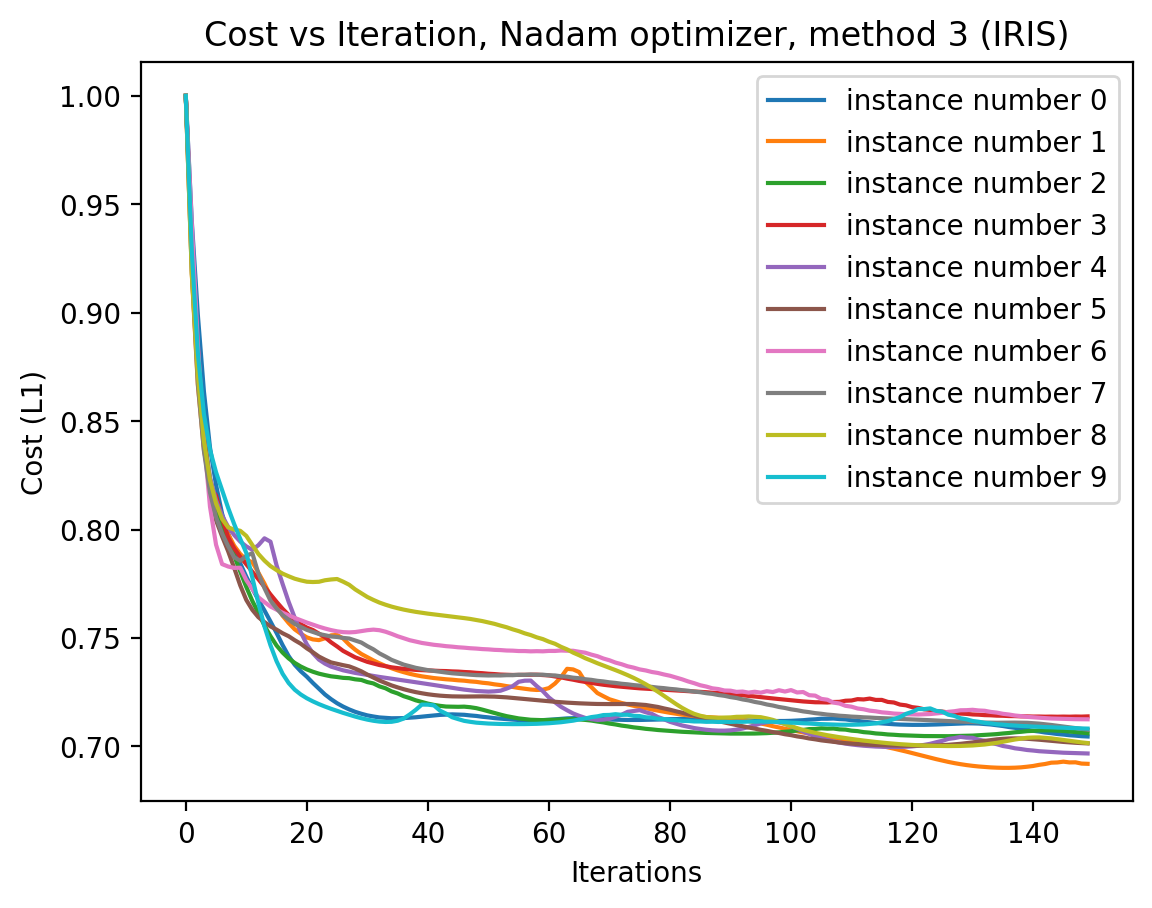

In [24]:
m = 3
# plot_results(losses[m], title=f'MSE loss, NADAM, method "{m}"', xlabel='Loss', ylabel='Iteration')

l_f = LossFunctions[m]

plt.rcParams['figure.dpi'] = DPI_RES
for i in range(len(l_f)):
    plt.plot(range(len(l_f.iloc[i])), l_f.iloc[i], label=f'instance number {i}')

plt.title(f'Cost vs Iteration, Nadam optimizer, method {m} ({DATA_SET})')
plt.xlabel("Iterations")
plt.ylabel(f"Cost (L1)")
plt.legend(loc='best')
plt.plot()

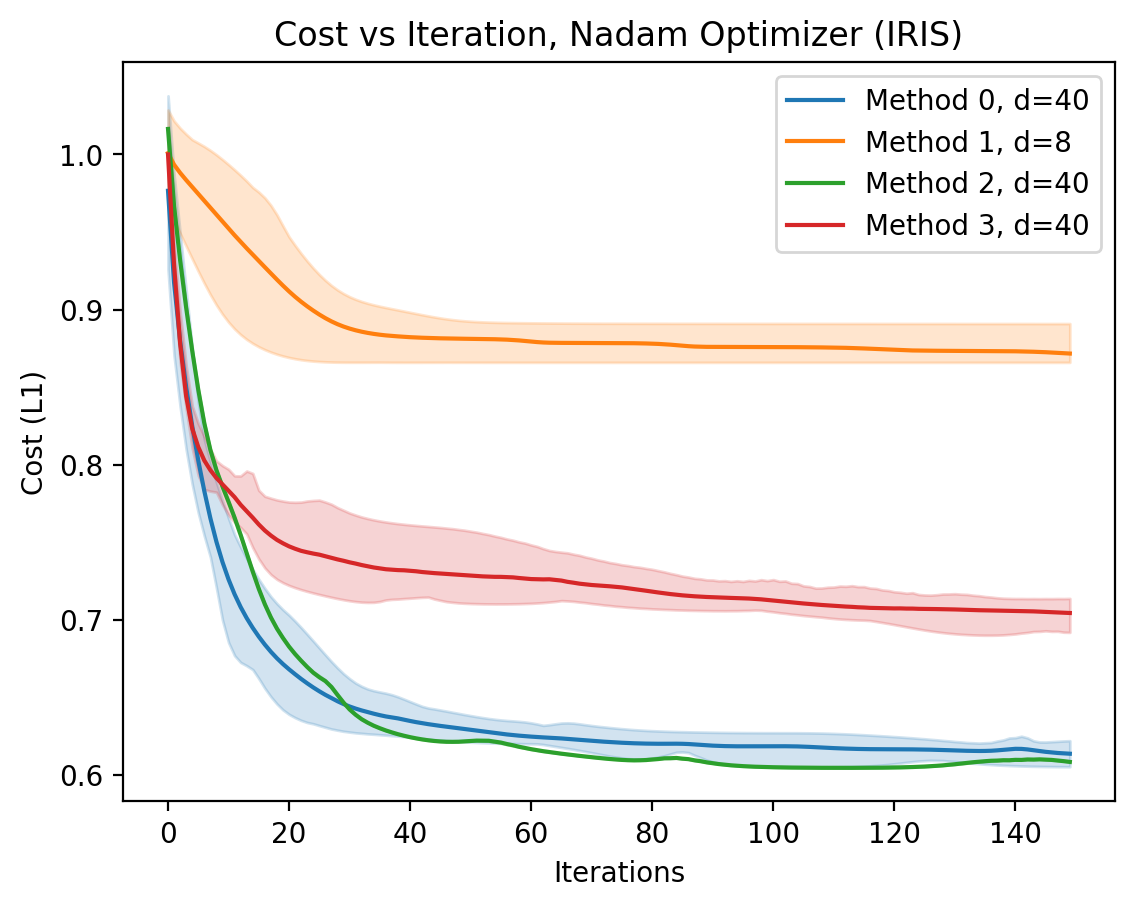

In [25]:
plot_objfn_range(LossFunctions, smooth_weight=0, d=d, ylabel='Cost (L1)', title=f'Cost vs Iteration, Nadam Optimizer ({DATA_SET})')

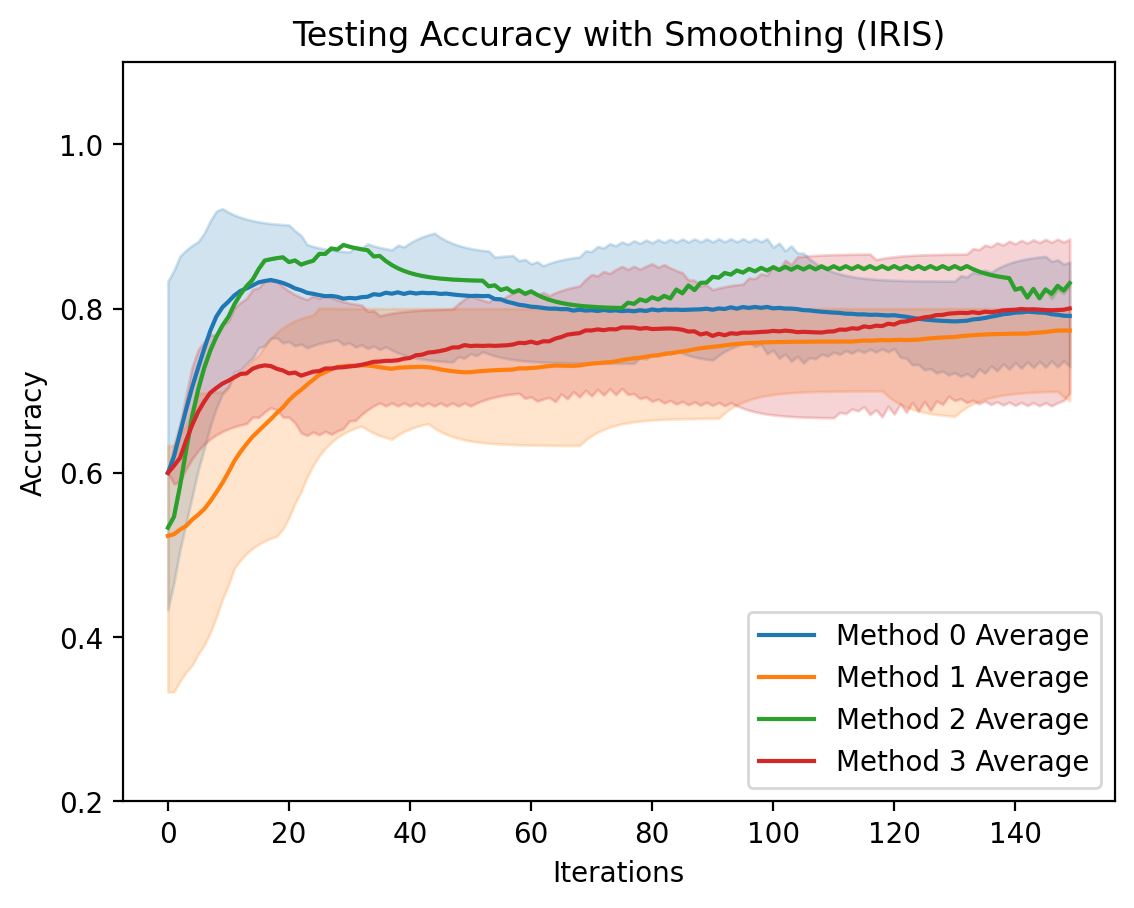

In [26]:
plot_score_range(test_scores, smooth_weight=0.80, title=f'Testing Accuracy with Smoothing ({DATA_SET})', ylabel='Accuracy')

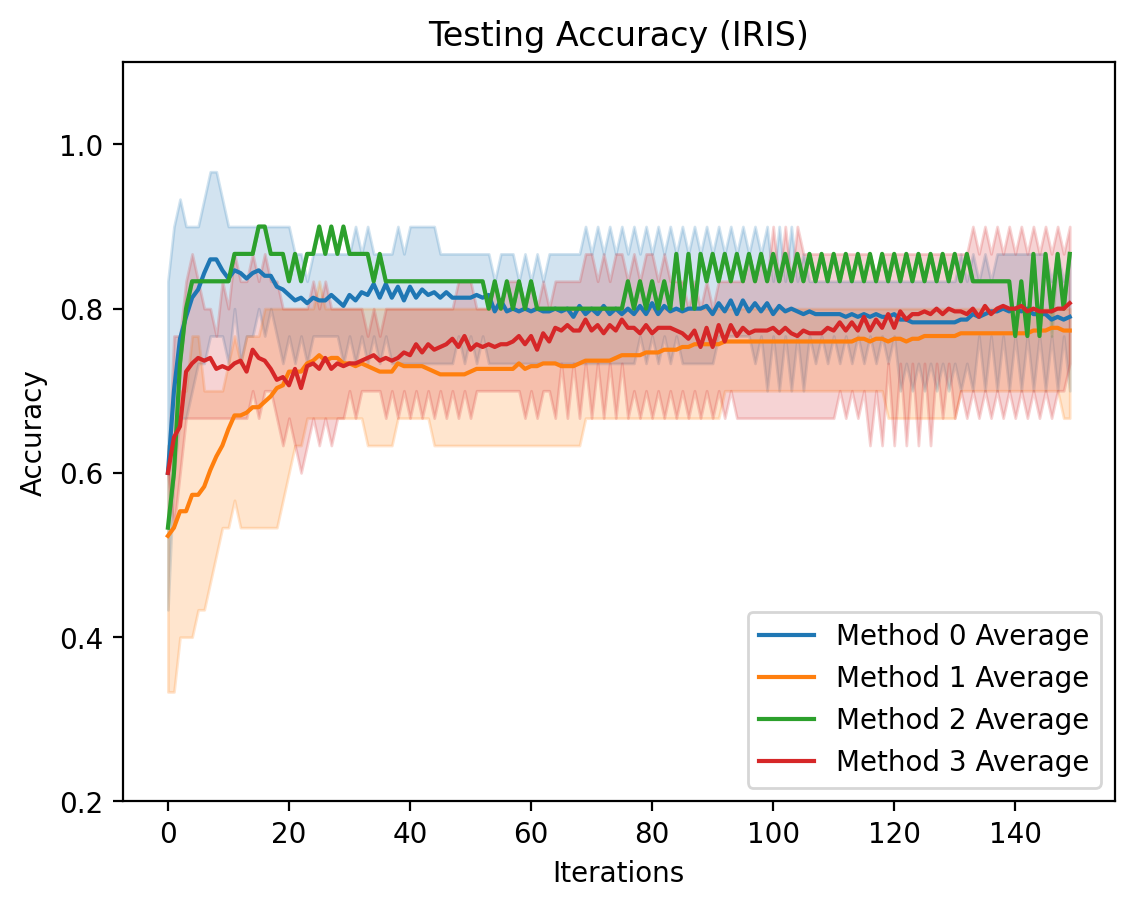

In [27]:
plot_score_range(test_scores, smooth_weight=0, title=f'Testing Accuracy ({DATA_SET})', ylabel='Accuracy')

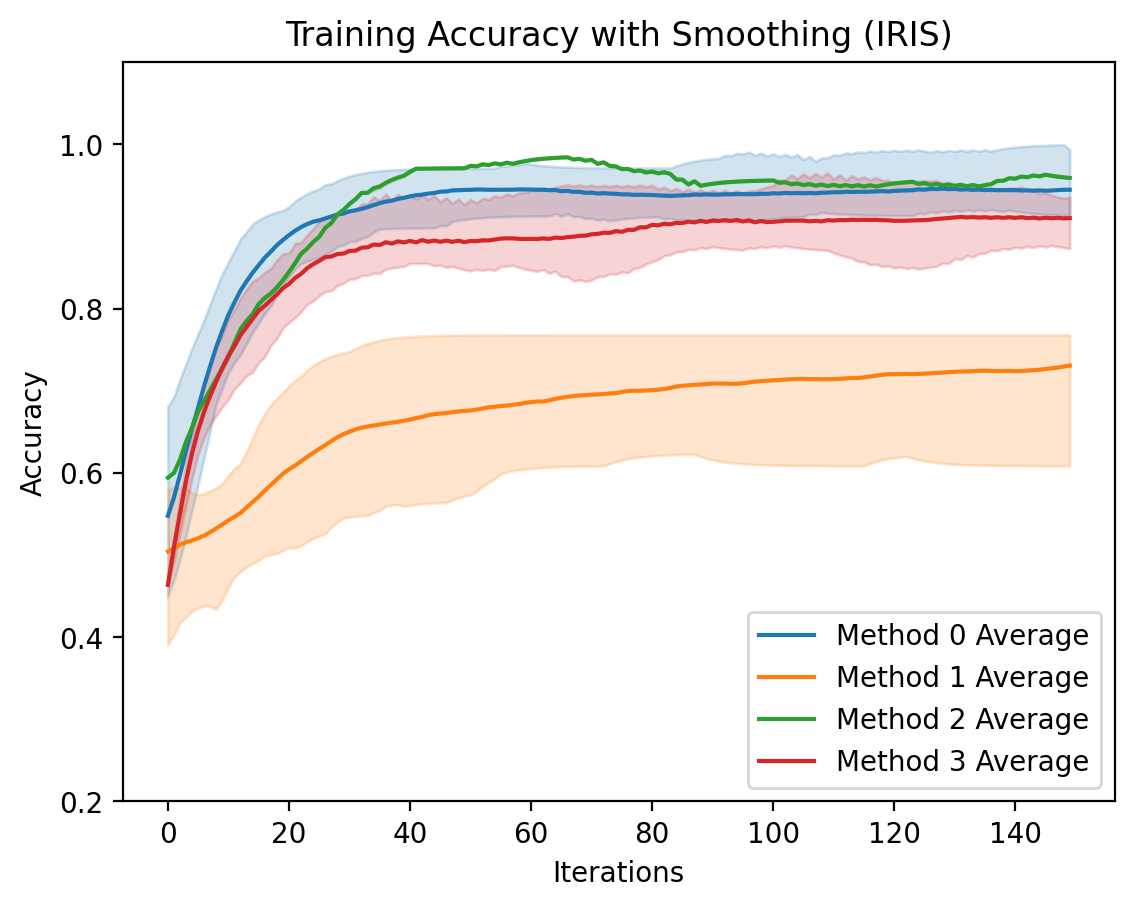

In [28]:
plot_score_range(train_scores, smooth_weight=0.80, title=f'Training Accuracy with Smoothing ({DATA_SET})', ylabel='Accuracy')

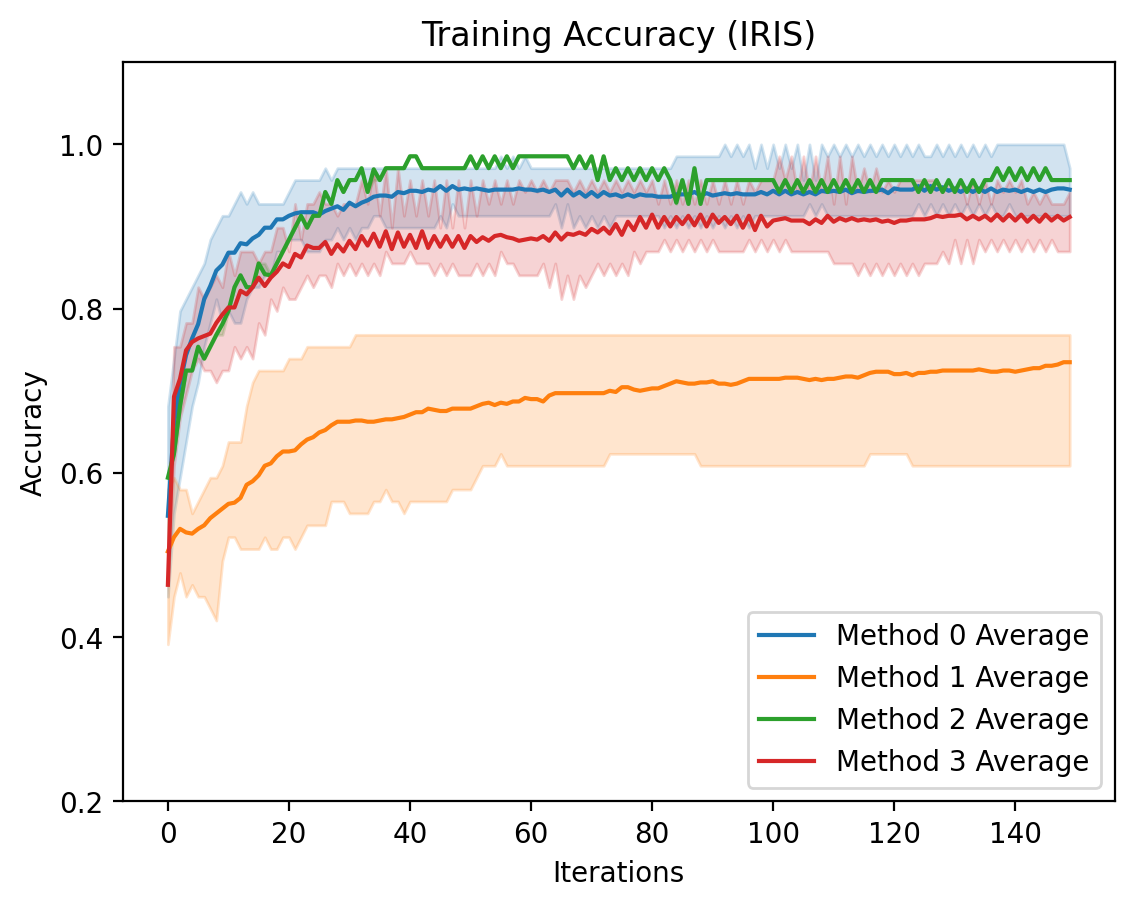

In [29]:
plot_score_range(train_scores, smooth_weight=0, title=f'Training Accuracy ({DATA_SET})', ylabel='Accuracy')

# Global Effective Dimension

[]

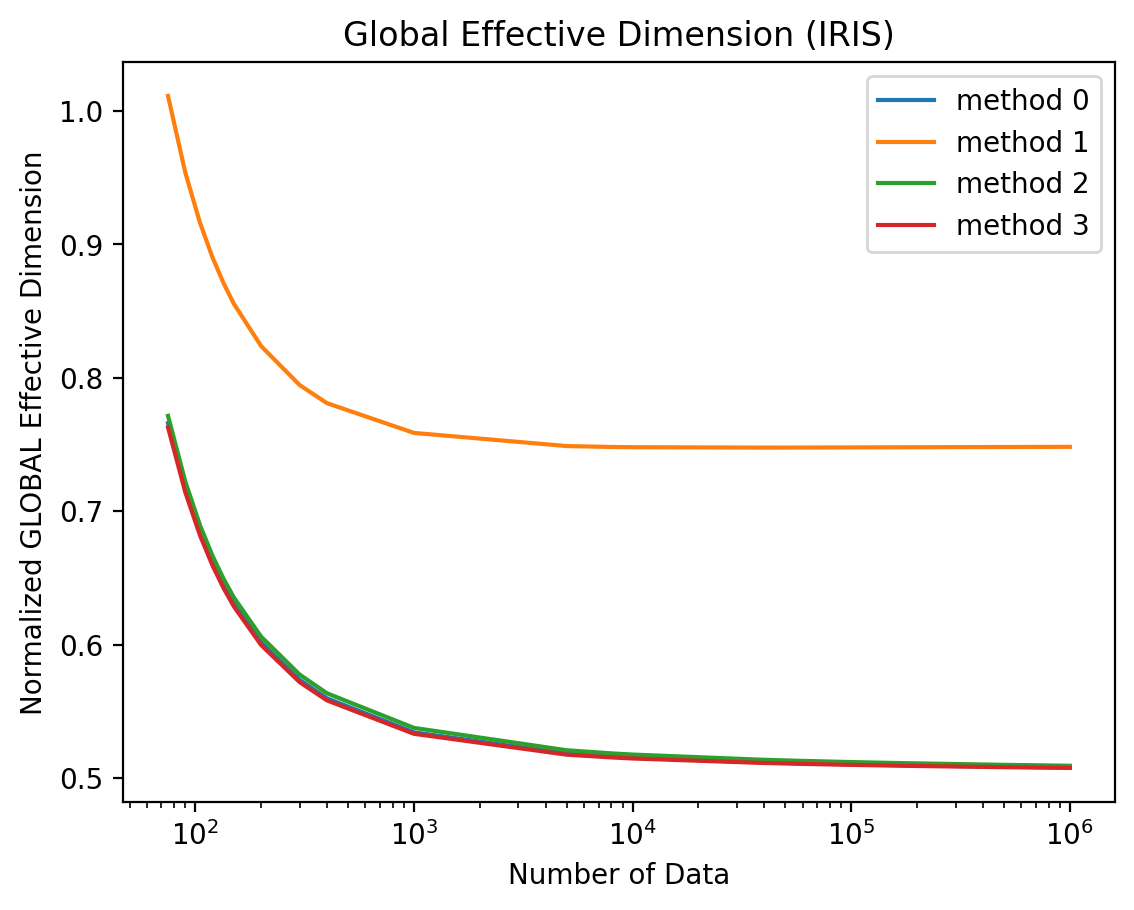

In [30]:
plt.rcParams['figure.dpi'] = DPI_RES
plt.title(f'Global Effective Dimension ({DATA_SET})')
plt.plot(n, np.array(Global_eff_0) / len(Weights_0[0].columns), label = 'method 0')
plt.plot(n, np.array(Global_eff_1) / len(Weights_1[0].columns), label = 'method 1')
plt.plot(n, np.array(Global_eff_2) / len(Weights_2[0].columns), label = 'method 2')
plt.plot(n, np.array(Global_eff_3) / len(Weights_3[0].columns), label = 'method 3')
plt.xlabel("Number of Data")
plt.ylabel("Normalized GLOBAL Effective Dimension")
plt.legend(loc='best')
plt.plot()
plt.semilogx()

[]

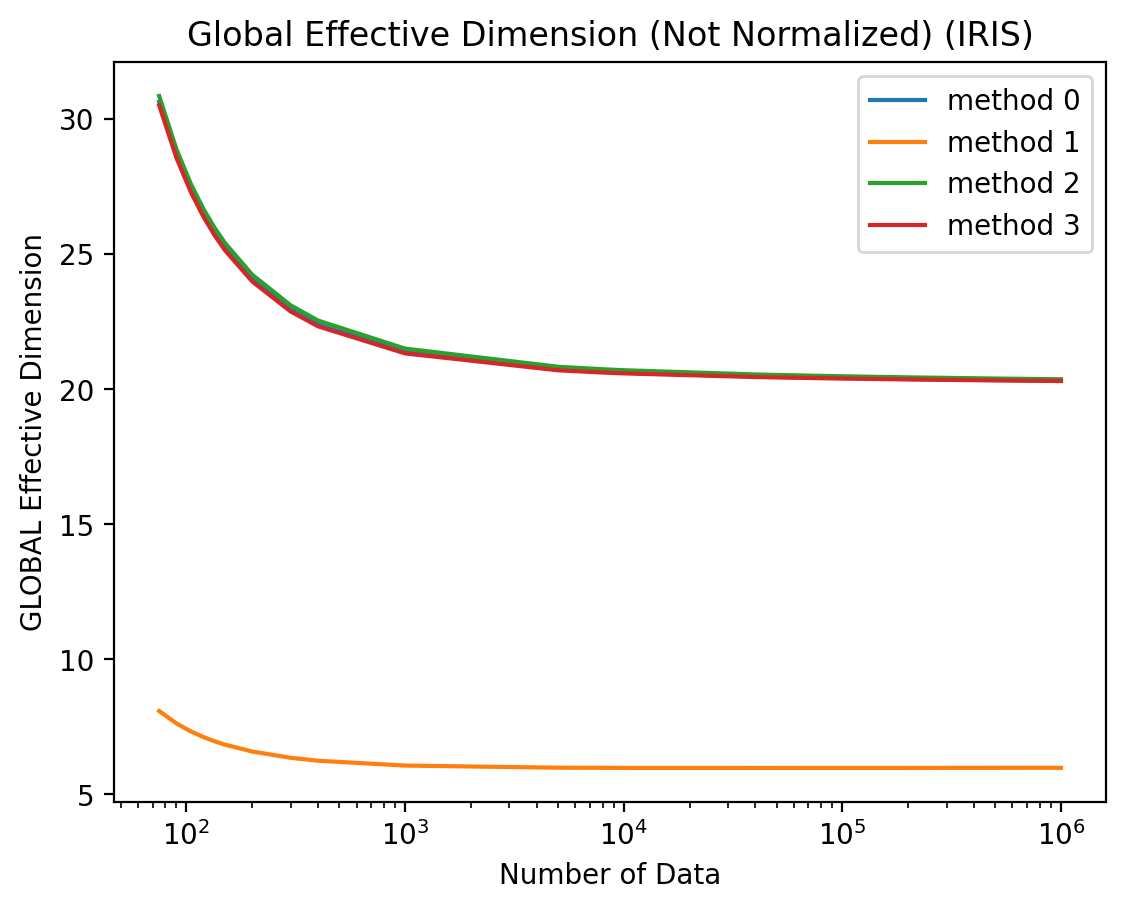

In [31]:
plt.rcParams['figure.dpi'] = DPI_RES
plt.title(f'Global Effective Dimension (Not Normalized) ({DATA_SET})')
plt.plot(n, np.array(Global_eff_0), label = 'method 0')
plt.plot(n, np.array(Global_eff_1), label = 'method 1')
plt.plot(n, np.array(Global_eff_2), label = 'method 2')
plt.plot(n, np.array(Global_eff_3), label = 'method 3')
plt.xlabel("Number of Data")
plt.ylabel("GLOBAL Effective Dimension")
plt.legend(loc='best')
plt.plot()
plt.semilogx()

In [32]:
!pip list | grep qiskit

qiskit                        0.41.0
qiskit-aer                    0.11.2
qiskit-experiments            0.4.0
qiskit-finance                0.3.4
qiskit-ibm-experiment         0.2.8
qiskit-ibm-runtime            0.8.0
qiskit-ibmq-provider          0.20.0
qiskit-machine-learning       0.5.0
qiskit-nature                 0.5.2
qiskit-optimization           0.5.0
qiskit-terra                  0.23.1


In [33]:
!pip list | grep torch

torch                         2.0.1
